In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing necessary libraries for data processing and model training
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import torchvision.transforms as T
import seaborn as sns


In [2]:
# Setting up the device for GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:
# Data augmentation and transformation for training and testing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [4]:
# Loading dataset and splitting into train, validation, and test sets
data_dir = '/Users/nisar/Downloads/Akhila/Dataset-1/'
full_data = datasets.ImageFolder(data_dir, transform=train_transforms)

# Splitting data into training and validation sets
dataset_size = len(full_data)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

# DataLoader creation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32)

# Displaying counts
print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Testing samples: {len(test_data)}")


Training samples: 4733, Validation samples: 1184, Testing samples: 5917


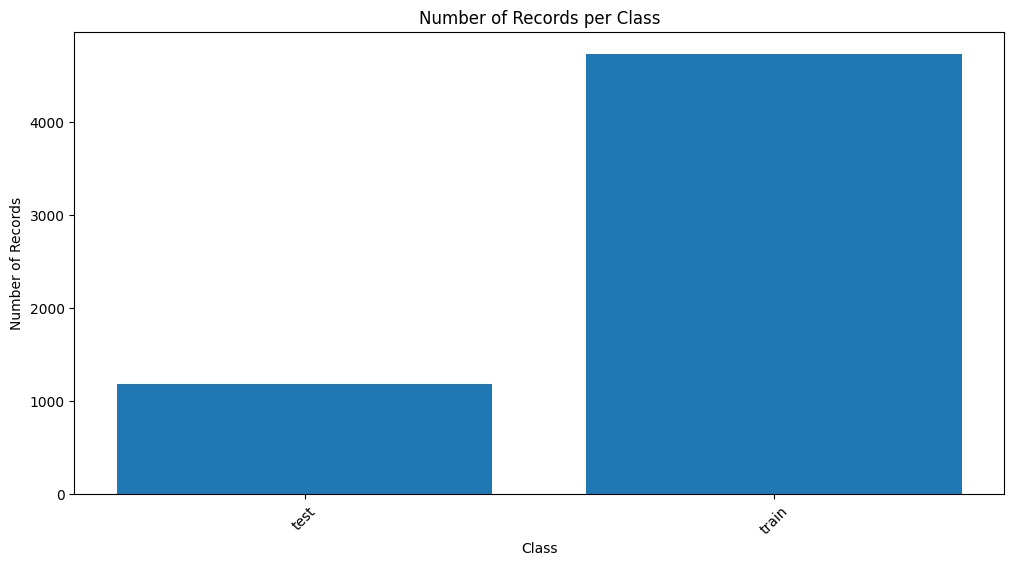

In [5]:
# Counting records per class and plotting
class_counts = {class_name: 0 for class_name in test_loader.dataset.classes}
for _, label in test_loader.dataset.samples:
    class_name = test_loader.dataset.classes[label]
    class_counts[class_name] += 1

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Records')
plt.title('Number of Records per Class')
plt.xticks(rotation=45)
plt.show()


In [6]:
# Load pre-trained VGG16 model and modify the final layer
vgg16 = models.vgg16(pretrained=True)

# Fine-tuning layers selectively
for name, param in vgg16.features.named_parameters():
    if '29' in name or '26' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_classes = len(test_loader.dataset.classes)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
vgg16 = vgg16.to(device)


c:\Users\nisar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nisar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

In [8]:
# Training loop setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = running_corrects.double() / total_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc.item())

    # Validation phase
    vgg16.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = vgg16(val_inputs)
            val_loss_batch = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += val_loss_batch.item() * val_inputs.size(0)
            val_corrects += torch.sum(val_preds == val_labels.data)
            val_samples += val_labels.size(0)

    epoch_val_loss = val_loss / val_samples
    epoch_val_acc = val_corrects.double() / val_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc*100:.2f}%", flush=True)


Epoch 1/10 - Train Loss: 0.5254, Train Acc: 80.31%, Val Loss: 0.5657, Val Acc: 77.45%
Epoch 2/10 - Train Loss: 0.4996, Train Acc: 80.63%, Val Loss: 0.5338, Val Acc: 77.45%
Epoch 3/10 - Train Loss: 0.4993, Train Acc: 80.63%, Val Loss: 0.5334, Val Acc: 77.45%
Epoch 4/10 - Train Loss: 0.4992, Train Acc: 80.60%, Val Loss: 0.5474, Val Acc: 77.45%
Epoch 5/10 - Train Loss: 0.4963, Train Acc: 80.63%, Val Loss: 0.5345, Val Acc: 77.45%
Epoch 6/10 - Train Loss: 0.4949, Train Acc: 80.63%, Val Loss: 0.5367, Val Acc: 77.45%
Epoch 7/10 - Train Loss: 0.4958, Train Acc: 80.63%, Val Loss: 0.5452, Val Acc: 77.45%
Epoch 8/10 - Train Loss: 0.4972, Train Acc: 80.63%, Val Loss: 0.5368, Val Acc: 77.45%
Epoch 9/10 - Train Loss: 0.4981, Train Acc: 80.63%, Val Loss: 0.5354, Val Acc: 77.45%
Epoch 10/10 - Train Loss: 0.4966, Train Acc: 80.63%, Val Loss: 0.5338, Val Acc: 77.45%


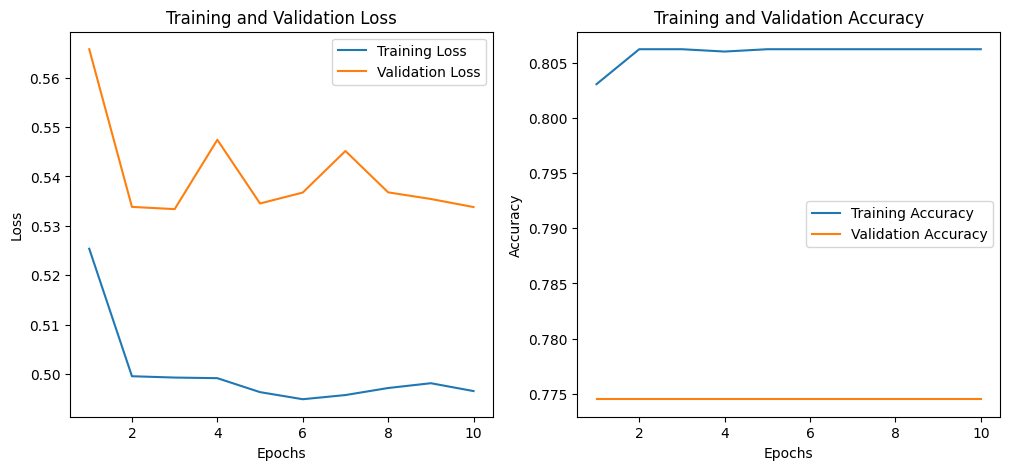

In [9]:
# Plotting loss and accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [10]:
# Model evaluation on test data
vgg16.eval()
all_preds = []
all_labels = []
all_features = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        features = vgg16.features(images).cpu().view(images.size(0), -1).numpy()
        all_features.append(features)



In [11]:
# Calculating performance metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


Test Accuracy: 79.99%
Precision: 63.98%
Recall: 79.99%
F1 Score: 71.10%


c:\Users\nisar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


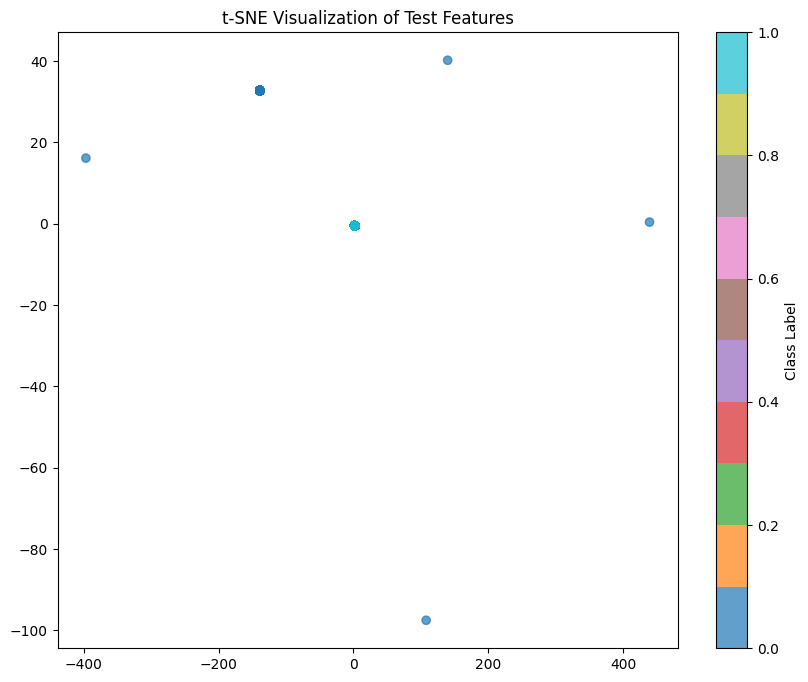

In [12]:
# Visualizing features using t-SNE
all_features = np.concatenate(all_features, axis=0)
all_labels = np.array(all_labels)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title("t-SNE Visualization of Test Features")
plt.show()


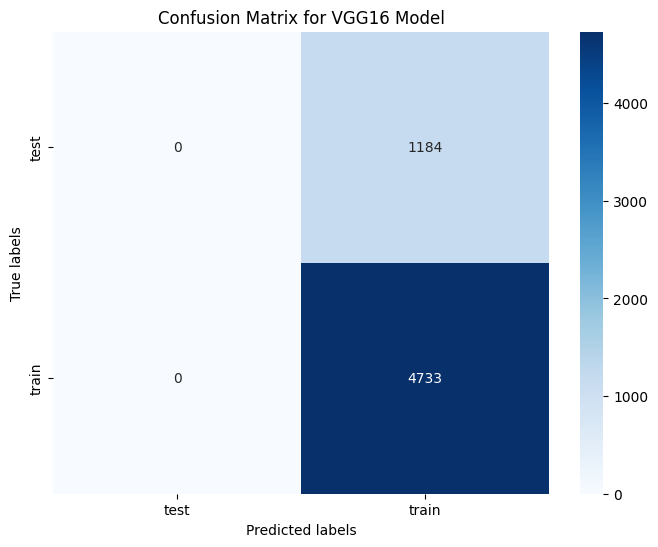

In [13]:
# Function to test the model and compute the confusion matrix
def test_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    return cm

conf_matrix = test_model(vgg16, test_loader, device)
class_names = test_loader.dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for VGG16 Model')
plt.show()
